<a href="https://colab.research.google.com/github/ZZongSeung/-/blob/main/lstm%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler


In [ ]:
df=pd.read_csv("제출용.csv",encoding="cp949")


In [ ]:
df['일자']=pd.to_datetime(df['일자'])
df2=df.sort_values("일자")
df2.index=df2['일자']
df2.head()

,Unnamed: 0,X,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,상장시가총액,미국금리,한국금리,월,연도
일자,,,,,,,,,,,,,,,,
2007-01-02,3177,1,2007-01-02,1435.26,0.80,0.06,1438.89,1439.71,1430.06,147739,2037041,705331659,5.25,4.5,1,2007
2007-01-03,3178,2,2007-01-03,1409.35,-25.91,-1.81,1436.42,1437.79,1409.31,203208,2611604,692674665,5.25,4.5,1,2007
2007-01-04,3179,3,2007-01-04,1397.29,-12.06,-0.86,1410.55,1411.12,1388.50,241172,2967081,686777867,5.25,4.5,1,2007
2007-01-05,3180,4,2007-01-05,1385.76,-11.53,-0.83,1398.60,1400.59,1372.36,277292,3394972,681185457,5.25,4.5,1,2007
2007-01-08,3181,5,2007-01-08,1370.81,-14.95,-1.08,1376.76,1384.65,1366.48,177592,2555241,673840181,5.25,4.5,1,2007


In [ ]:
plt.plot(df2['일자'],df2['종가'])
plt.show()

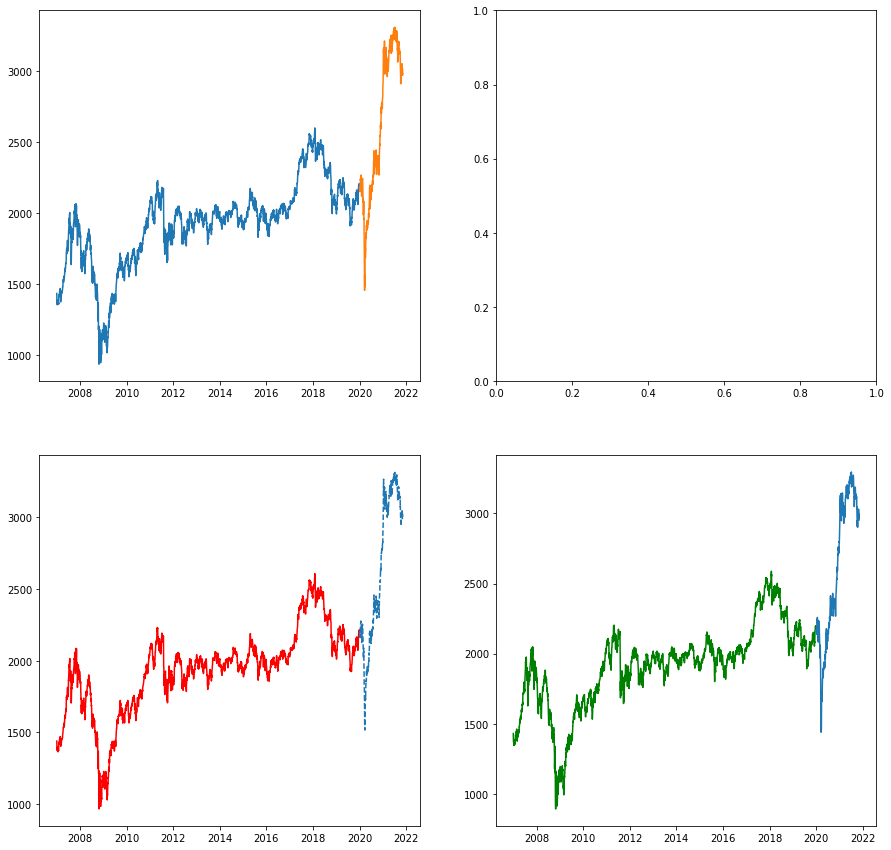

In [ ]:
####데이터 분리 ####
split_date = pd.Timestamp('31-12-2019')
#시가	고가	저가	거래량
train_data=pd.DataFrame(df2.loc[:split_date,['종가','고가','저가']])
test_data=pd.DataFrame(df2.loc[split_date:,['종가','고가','저가']])

fig,axs=plt.subplots(2,2,figsize=(15,15))

axs[0,0].plot( train_data['종가'])
axs[1,0].plot(train_data.index, train_data['고가'],color='red')
axs[1,1].plot(train_data.index, train_data['저가'],color='green')


axs[0,0].plot(test_data['종가'])
axs[1,0].plot(test_data.index, test_data['고가'],linestyle='--')
axs[1,1].plot(test_data.index, test_data['저가'],linestyle='solid')


In [ ]:
train_scale=pd.DataFrame(train_scale)
train_scale.columns=train_data.columns

In [ ]:
scaler = MinMaxScaler() 
total=pd.DataFrame(df2[['종가','고가','저가']])
total_scale=scaler.fit_transform(total)
train_scale=scaler.fit_transform(train_data)
test_scale= scaler.transform(test_data)

In [ ]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)



feature_cols = ['고가', '저가']
label_cols = ['종가']

train_feature = train_scale[feature_cols]
train_label = train_scale[label_cols]

from sklearn.model_selection import train_test_split

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((2554, 20, 2), (639, 20, 2))

In [ ]:
test_scale=pd.DataFrame(test_scale)
test_scale.columns=['종가','고가','저가']

test_feature = test_scale[feature_cols]
test_label = test_scale[label_cols]

test_feature.shape, test_label.shape

test_feature, test_label = make_dataset(test_feature, test_label, 20)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential() #레이어 생성
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False) #16개의 LSTM 레이어 생성,활성화 함수는 렐루(hidden layer)
          )

model.add(Dense(1)) #출력층 ㅅㅂ 왜 1로 했지?
#

In [ ]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')#손실함수는 MSE, 최적화함수
early_stop = EarlyStopping(monitor='val_loss', patience=5) #조기종료 실시_다 할 필요는 없음, patience=5는 5번 연속으로 값이 향상, 즉 손실함수의 값이 줄지 않으면 종료  

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')#저장 
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto') #저장

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint]) #확률적 경사하강법에서 파생_즉 신경망의 파생된 개념이기 때문에 batch_size나 등등을 이용함.

Epoch 1/200
158/160 [============================>.] - ETA: 0s - loss: 0.1773
Epoch 1: val_loss improved from inf to 0.00804, saving model to model/tmp_checkpoint.h5
160/160 [==============================] - 5s 16ms/step - loss: 0.1755 - val_loss: 0.0080
Epoch 2/200
159/160 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 2: val_loss improved from 0.00804 to 0.00311, saving model to model/tmp_checkpoint.h5
160/160 [==============================] - 3s 17ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 3/200
159/160 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 3: val_loss improved from 0.00311 to 0.00225, saving model to model/tmp_checkpoint.h5
160/160 [==============================] - 3s 16ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 4/200
157/160 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 4: val_loss improved from 0.00225 to 0.00209, saving model to model/tmp_checkpoint.h5
160/160 [==============================] - 3s 18ms/ste

In [1]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) #에포크는 6으로 측정
plt.title('검증손실과 train_scale의 검증 손실 확인')

NameError: ignored

80/80 [==============================] - 0s 4ms/step - loss: 2.1711e-04
0.00021711448789574206
20/20 [==============================] - 0s 4ms/step - loss: 2.2577e-04
0.00022577120398636907
0


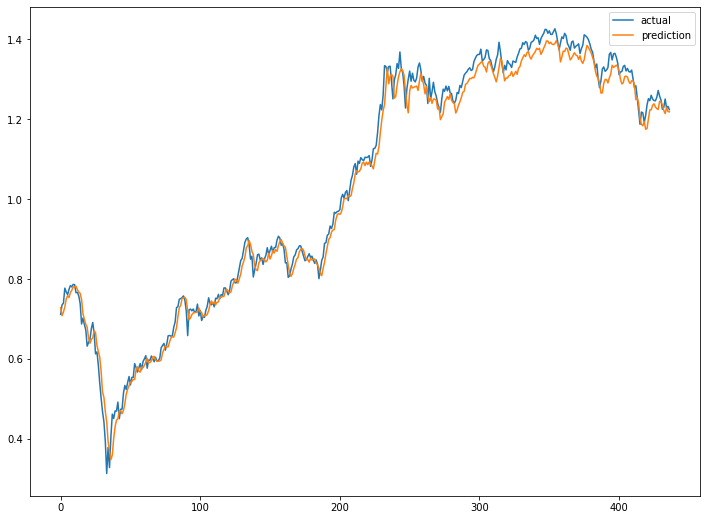

In [ ]:
model.load_weights(filename)
pred = model.predict(test_feature)
##현재 모델에 대한 R-square
print(model.evaluate(x_train,y_train))
print(model.evaluate( x_valid, y_valid))
##비슷함

print(early_stop.stopped_epoch) #에포크는 1로 지정

##검증점수 확인
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show())
##종료
#강평
  # LSTM은 기반이 되는 데이터들이 많을수록 예측에 도움이 된다
  # 인공신경망, 심층신경망에서 파생된 개념이므로 어려운 개념이 절대 아니다. 
  # 알고 쓰자 ^^